In [1]:
import pandas as pd
import numpy as np

import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme()

from model import BestFitModel, Predict, Model

In [2]:
MAX_OFFSET = 45 # the max number of days between cases and deaths to test
startDate = np.datetime64('2020-06-24') # the earliest date in the data to use (about when the data becomes less noisy)
country = 'USA' # the country code to analyse

In [3]:
# load and filter the dataset to just the locale and period of interest
raw_data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', usecols=['date', 'iso_code', 'new_deaths', 'new_cases', 'new_deaths_smoothed', 'new_cases_smoothed'], parse_dates=['date'])
df = raw_data[(raw_data.iso_code == country) & (raw_data.date >= startDate) &
    (~raw_data.new_deaths.isnull()) &
    (~raw_data.new_cases.isnull()) &
    (~raw_data.new_deaths_smoothed.isnull()) &
    (~raw_data.new_cases_smoothed.isnull())]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 52848 to 53029
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   iso_code             182 non-null    object        
 1   date                 182 non-null    datetime64[ns]
 2   new_cases            182 non-null    float64       
 3   new_cases_smoothed   182 non-null    float64       
 4   new_deaths           182 non-null    float64       
 5   new_deaths_smoothed  182 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 10.0+ KB


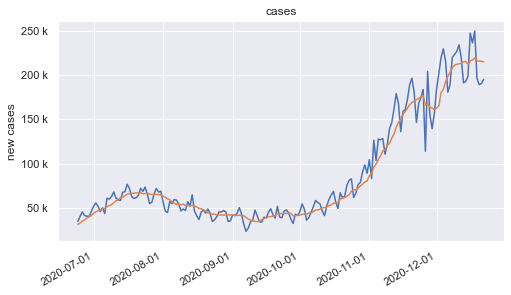

In [4]:
fig, ax = plt.subplots()

ax.set_ylabel("new cases") 
ax.plot(df["date"], df[['new_cases']])
ax.plot(df["date"], df[['new_cases_smoothed']])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_formatter(ticker.EngFormatter())

fig.autofmt_xdate()
fig.set_size_inches(8, 4.5)

plt.title("cases") 
plt.show()
fig.savefig("cases.png", bbox_inches='tight')

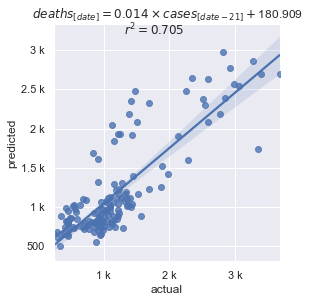

In [5]:
model = BestFitModel(df[['new_cases']], df['new_deaths'], MAX_OFFSET)

fig = sns.lmplot(data= model.data, x="actual", y="predicted").fig
fig.suptitle(rf"$r^2={round(model.r2,3)}$", fontsize=12)
fig.set_size_inches(3.75, 3.75)

ax = fig.axes[0]
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title(fr'$deaths_{{[date]}}={round(model.linearRegression.coef_[0], 3)} \times cases_{{[date-{model.offset}]}} + ${round(model.linearRegression.intercept_, 3)}', fontsize=12)

fig.savefig("daily.png", bbox_inches='tight')

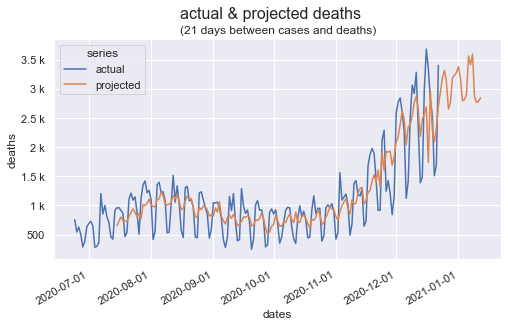

In [6]:
data = Predict(model, df["date"], df[['new_cases']], df['new_deaths'])

ax = sns.lineplot(data=data, x="dates", y="deaths", hue="series")
ax.set_title(f'({model.offset} days between cases and deaths)', fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_formatter(ticker.EngFormatter())

fig = ax.figure
fig.set_size_inches(8, 4.5)
fig.suptitle('actual & projected deaths', fontsize=16)
fig.autofmt_xdate()

fig.savefig("dailycomparison.png", bbox_inches='tight')

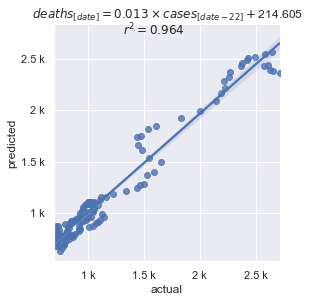

In [7]:
model = BestFitModel(df[['new_cases_smoothed']], df['new_deaths_smoothed'], MAX_OFFSET)

fig = sns.lmplot(data= model.data, x="actual", y="predicted").fig
fig.suptitle(rf"$r^2={round(model.r2,3)}$", fontsize=12)
fig.set_size_inches(3.75, 3.75)

ax = fig.axes[0]
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title(fr'$deaths_{{[date]}}={round(model.linearRegression.coef_[0], 3)} \times cases_{{[date-{model.offset}]}} + ${round(model.linearRegression.intercept_, 3)}', fontsize=12)

fig.savefig("smoothed.png", bbox_inches='tight')

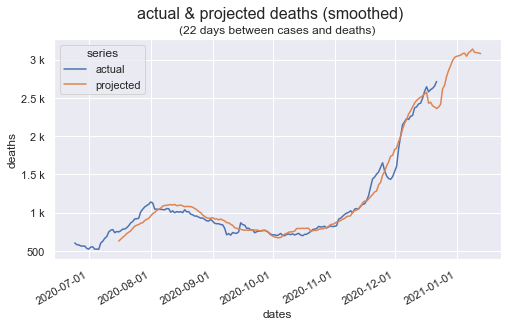

In [8]:
data = Predict(model, df["date"], df[['new_cases_smoothed']], df['new_deaths_smoothed'])

ax = sns.lineplot(data=data, x="dates", y="deaths", hue="series")
ax.set_title(f'({model.offset} days between cases and deaths)', fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_formatter(ticker.EngFormatter())

fig = ax.figure
fig.set_size_inches(8, 4.5)
fig.suptitle('actual & projected deaths (smoothed)', fontsize=16)
fig.autofmt_xdate()

fig.savefig("smoothedcomparison.png", bbox_inches='tight')

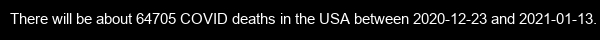

In [70]:
from PIL import Image, ImageDraw, ImageFont

today = np.datetime64('today') 
max = data["dates"].max()
deaths = data.query("series == 'projected' & dates >= @today").sum()
s = f'There will be about {round(deaths["deaths"])} COVID deaths in the {country} between {today} and {max.strftime("%Y-%m-%d")}.'
img = Image.new('RGB', (600, 40))
d = ImageDraw.Draw(img)
font = ImageFont.truetype("arial.ttf", 15)
d.text((10, 10), s, font=font)
img.save("deaths.jpg")
img